# 셀로우 포커스 활용 다른 사진으로 실습


In [1]:
# 필요한 라이브러리 import 하기

import os
import urllib
import cv2 
import numpy as np
from pixellib.semantic import semantic_segmentation
import matplotlib.pyplot as plt

`urllib` 웹에서 데이터 다운로드 할 때 사용
`cv2` opencv로 이미지 처리
`pixellib` 시맨틱 세그멘테이션 사용 라이브러리

(1128, 1128, 3)


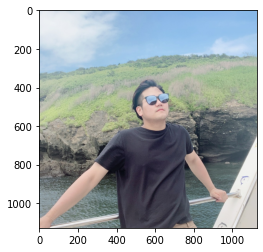

In [2]:
img_path = os.getenv("HOME")+"/aiffel/human_segmentation/images/my_image3.jpg"
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션으로 사람 분리하기

#### 세그멘테이션(Segmentation)이란
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 **이미지 세그멘테이션(image segmentation)**이라고 한다.

**시맨틱 세그멘테이션(sementic segmentation)** 물리적 의미 단위로 인식하는 세그멘테이션 사람, 자동차, 비행기 등 물리적인 단위로 분류하는 방법

시멘틱세그멘테이션은 사람이라는 추상적인 정보를 이미지에서 추출해 내는 방법, 사람이 누구던지 같은 라벨로 표현하지만 **인스턴스 세그멘테이션(Instance segmentation)**은 사람 개개인별로 다른 라벨을 가지게 한다. 여러사람이 한 이미지에 등장할 때 객체를 분할해서 인식하는 것이 목표이다.





In [3]:
model_path = os.getenv('HOME') + '/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
model = semantic_segmentation()
model.load_pascalvoc_model(model_path)

앞의 예제를 통해 모델을 다운로드 했기 때문에 경로에서 불러오는 코드로 변경

In [4]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

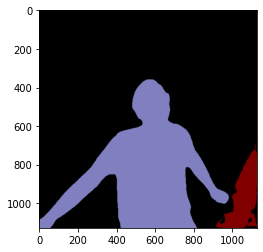

In [6]:
plt.imshow(output)
plt.show()

In [7]:
segvalues

{'class_ids': array([ 0,  4, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
boat
person


In [9]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype = int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind>>channel) & 1) << shift
    ind >>= 3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [10]:
colormap[15]

array([192, 128, 128])

In [11]:
seg_color = (128, 128, 192)

항상 잊지 말아야 할것은 BGR순서 이므로 RGB로 바꿔서 작성해 준다.

(1128, 1128)


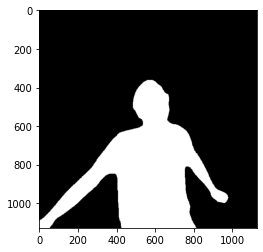

In [12]:
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

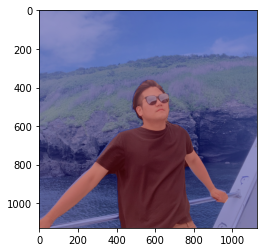

In [13]:
img_show = img_orig.copy()

# True, False 값을 각각 255, 0으로 바꿔줌
img_mask = seg_map.astype(np.uint8) * 255

# 255, 0을 적당한 색상으로 바꿔본다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 흐리게 만들기

`blur()`함수 사용

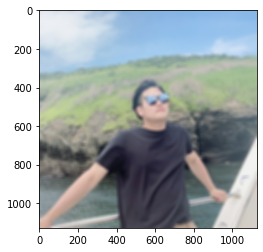

In [14]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (20,20))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

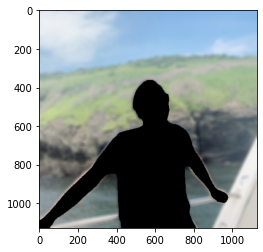

In [15]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경과 사람 합치기

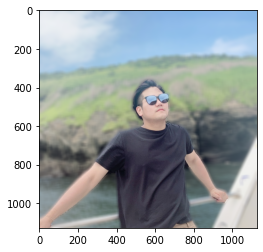

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 바꾸기

In [17]:
import pixellib
from pixellib.tune_bg import alter_bg

In [18]:
background_path = os.getenv("HOME")+"/aiffel/human_segmentation/images/background.jpg"

In [19]:
change_back = alter_bg()
change_back.load_pascalvoc_model(model_path)

img_dir = os.getenv("HOME")+'/aiffel/human_segmentation/images'

combine_img = change_back.change_bg_img(f_image_path = img_path, b_image_path = background_path, output_image_name = os.path.join(img_dir, "combined_img.jpg"))



`change_bg_img()` 사용해서 간편하게 배경을 바꿔줬다   
f_image_path = 전경 이미지   
b_image_path = 바꿀 배경 이미지   
output_image_name = 배경을 바꾼 새 이미지   

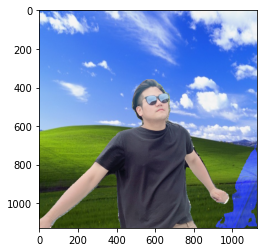

In [20]:
plt.imshow(cv2.cvtColor(combine_img, cv2.COLOR_BGR2RGB))
plt.show()

배경을 바꾸는건 다 좋지만 아쉽게도 테두리가 완벽하지 않고 옆에 있던 기둥이 그대로 같이 넘어온 것을 확인할 수 있다.

# 다른 사진 마무리




앞의 사진과 같이 다른 과정은 문제없이 진행되었다  
하지만 앞과 다르게 배경을 바꾸면서 확실히 사진의 몇 가지 문제점이 눈에 보였다.   

완벽하게 내 몸만 딱 추출이 된 것이 아니라 라인이 애매하게 조금 겹치면서 끊어진 점이나, 옆에 있던 기둥이 그대로 파란색으로 넘어온 것을 확인할 수 있다.   

그래도 이번 사진을 사용하면서 꽤나 놀라웠던 점은 배경에서 배라고 판단할만한 요소들이 크게 보이지 않는데 바다를 통해서 boat를 인식한 것인지 배를 인식했다는 것이 꽤나 놀라웠던 점이다.   

이번 노드의 마지막이 segmentation의 한계에 대해서 해결방안을 제시하고 새로운 해결방안을 제시해보는 것인데, 솔직히 잘 모르겠다  
이번 노드를 진행하면서 사용했던 segmentation의 원리는 심도를 사용해 거리를 통한 구별을 하지만 그 정확도가 완벽하지 못하다는 점이다.  

이를 해결하기위해 올려놓은 다양한 링크들을 보면, 구글의 struct2Depth와 IR(적외선) 카메라를 결합해 3D depth sensing과 관련해서 글을 올려놓았지만 솔직히 완벽하게 이해하지 못했고 어려워서 잘 모르겠다.

솔직히 소프트웨어를 통해 하드웨어의 현실적 한계를 극복하는 것들이 많은데 정말 간편한 방법으로는 하드웨어를 빨리 개발하길 바라는게 제일 나을 지도 모르겠다. 일해라 삼성


솔직하게 아직 관련된 지식이 많이 없는 상태에서 해결책을 제시하라고 하니 오히려 더 정신이 없고 멘탈이 나갈 것 같아 고민하다가 모르겠다는 결론을 내리기로 했다.
다음번에 다시한번 생각하게 된다면 나의 무지에 대해서 한탄하며 새로운 아이디어가 많이 나오기를
